# Time Series Analysis of the Stock Market 
## Prediction whether closing price of S&P 500 Index next day will be higher than today or not  (Classification problem)

<ul>
    <li><a href="#Load-Data">Load Data</a></li>
    <li><a href="#Data-Preprocessing">Data Preprocessing</a></li>
    <li><a href="#Single-models">Single models</a></li>
        <ul>
            <li><a href="#Linear-model">Linear model</a></li>
            <li><a href="#KNN">KNN</a></li>
        </ul>
    <li><a href="#Ensemble-methods">Ensemble methods</a></li>
        <ul>
            <li><a href="#Random-Forest-(bagging-method)">Random Forest (bagging-method)</a></li>
            <li><a href="#Gradient-Boosting-(boosting-method)">Gradient Boosting (boosting-method)</a></li>
            <li><a href="#Multilayer-perceptron">Multilayer perceptron</a></li>
        </ul>
    <li><a href="#Summary">Summary</a></li>
</ul>

## Load Data

In [2]:
import numpy as np
from pandas.io import data
import datetime

In [3]:
# download S&P 500 data from 1995-01-01 up to nowadays
start = datetime.datetime(1995, 1, 1)
end = datetime.datetime(2016, 11, 30)

df = data.DataReader("^GSPC", 'yahoo', start, end).asfreq('W-FRI', method='pad')[['Adj Close', 'Volume']]
vix = data.DataReader("^VIX", 'yahoo', start, end).asfreq('W-FRI', method='pad')['Adj Close']
df['vix'] = vix

In [4]:
df.describe()

,Adj Close,Volume,vix
count,1143.000000,1.143000e+03,1143.000000
mean,1263.893658,2.439918e+09,20.183132
std,395.468367,1.779349e+09,8.300951
min,460.679993,1.499000e+07,10.020000
25%,1027.335022,9.308000e+08,14.185000
50%,1233.420044,1.933010e+09,18.469999
75%,1430.325012,3.689675e+09,23.590000
max,2213.350098,1.145623e+10,79.129997


In [5]:
import matplotlib.pyplot as plt
plt.style.use('ggplot')

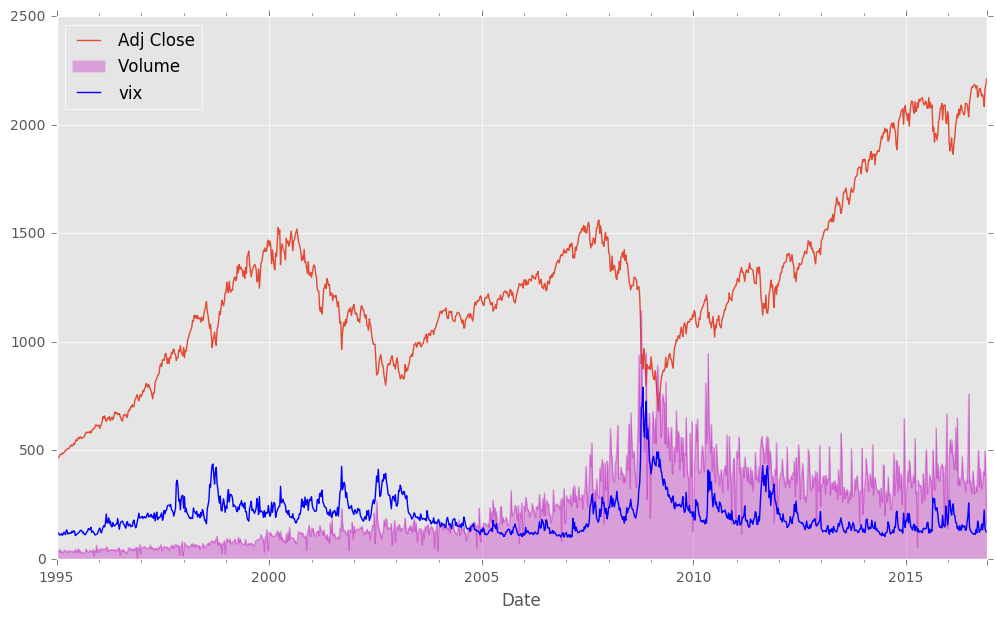

In [6]:
# let's take a brief look at the data
plt.figure(figsize=(12,7))
df['Adj Close'].plot(legend=True)
(df['Volume'] / 1e7).plot.area(alpha=0.3, legend=True,color='m')
(df['vix']* 10).plot(legend=True,color='b')
plt.show()

## Data Preprocessing
To perform predictive analysis we need to do some preprocessing steps. In case of the financial data the widely used approach is calculating log returns: ln(Xt/Xt-1)

In [7]:
df['log_return'] = np.log(df['Adj Close'] / df['Adj Close'].shift(1))

In [8]:
from sklearn import preprocessing

In [9]:
# rescale data
scaler1 = preprocessing.MinMaxScaler(feature_range=(0, 1))
df['Volume_scaled'] = scaler1.fit_transform(df['Volume'].astype(float).values.reshape(-1,1))
scaler2 = preprocessing.MinMaxScaler(feature_range=(0, 1))
df['vix_scaled'] = scaler2.fit_transform(df['vix'].values.reshape(-1,1))

We assign label "1" for values which log return equal or greater than zero and "0" for values which log return less than zero.

In [11]:
df['labels'] = 0
df['labels'].ix[df['log_return'] >= 0.0] = 1

In [12]:
df.dropna().describe()

,Adj Close,Volume,vix,log_return,Volume_scaled,vix_scaled,labels
count,1142.000000,1.142000e+03,1142.000000,1142.000000,1142.000000,1142.000000,1142.000000
mean,1264.596997,2.441785e+09,20.189308,0.001374,0.212109,0.147147,0.561296
std,394.925785,1.779008e+09,8.301960,0.024154,0.155491,0.120127,0.496446
min,464.779999,1.499000e+07,10.020000,-0.200838,0.000000,0.000000,0.000000
25%,1027.875030,9.329000e+08,14.195000,-0.011296,0.080228,0.060411,0.000000
50%,1233.550049,1.953015e+09,18.479999,0.002681,0.169389,0.122414,1.000000
75%,1430.412506,3.691022e+09,23.605001,0.014416,0.321297,0.196571,1.000000
max,2213.350098,1.145623e+10,79.129997,0.113559,1.000000,1.000000,1.000000


In [13]:
X = df[['log_return', 'Volume_scaled', 'vix_scaled']].ix[1:] # dropna
y = df['labels'].ix[1:] # dropna

# split data to train/test datasets
train_size = int(X.shape[0] * 0.8)

X_train, X_test = X.ix[:train_size], X.ix[train_size:]
y_train, y_test = y.ix[:train_size], y.ix[train_size:]

X_train.shape, X_test.shape, y_train.shape, y_test.shape

((913, 3), (229, 3), (913,), (229,))

## Single models

### Linear model

In [14]:
from sklearn import model_selection, linear_model, ensemble, neighbors
seed = 7
n_split = 5
cv = model_selection.TimeSeriesSplit(n_splits=n_split)

In [15]:
def plot_learning_curve(estimator, hyperparameter, X, y, cv):
    """
    Generate a simple plot of the test and training learning curve.

    Parameters
    ----------
    estimator : object type that implements the "fit" and "predict" methods
        An object of that type which is cloned for each validation.

    hyperparameter : dict
        Parameter to tune.

    X : array-like, shape (n_samples, n_features)
        Training vector, where n_samples is the number of samples and
        n_features is the number of features.

    y : array-like, shape (n_samples) or (n_samples, n_features), optional
        Target relative to X for classification or regression;
        None for unsupervised learning.

    cv : int, cross-validation generator or an iterable, optional
        Determines the cross-validation splitting strategy.
        Possible inputs for cv are:
          - None, to use the default 3-fold cross-validation,
          - integer, to specify the number of folds.
          - An object to be used as a cross-validation generator.
          - An iterable yielding train/test splits.

        For integer/None inputs, if ``y`` is binary or multiclass,
        :class:`StratifiedKFold` used. If the estimator is not a classifier
        or if ``y`` is neither binary nor multiclass, :class:`KFold` is used.

        Refer :ref:`User Guide <cross_validation>` for the various
        cross-validators that can be used here.
    """
    
    scores_avg, scores_std = [], []

    for k, vals in hyperparameter.items():
        for val in vals:
            estimator.set_params(**{k:val})
            score = model_selection.cross_val_score(estimator, X, y, cv=cv, scoring='accuracy')
            scores_avg.append(score.mean())
            scores_std.append(score.std())

    scores_avg, scores_std = np.array(scores_avg), np.array(scores_std)
    std_err = scores_std / np.sqrt(n_split)
    
    plt.plot(hyperparameter.values()[0], scores_avg)
    plt.fill_between(hyperparameter.values()[0], scores_avg-std_err, scores_avg+std_err, alpha=0.5)
    plt.title('learning curve +/- std error')
    plt.xlabel(k)
    plt.ylabel('Score')
    plt.ylim(0, 1.1)
    plt.show()

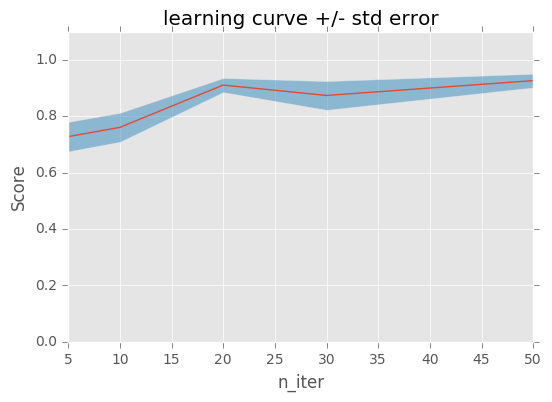

In [16]:
sgd = linear_model.SGDClassifier(random_state=seed, shuffle=False, loss='squared_hinge', penalty='l2')
plot_learning_curve(sgd, {'n_iter':[5,10,20,30,50]}, X_train, y_train, cv)

### KNN

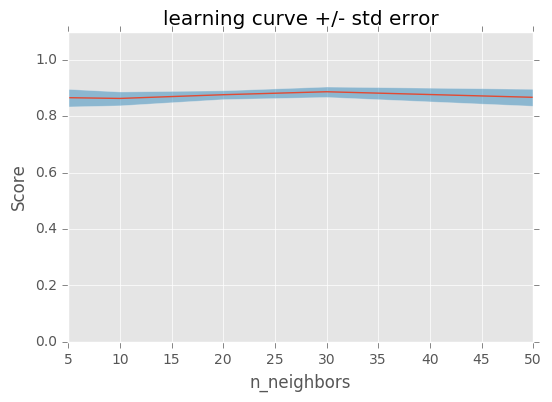

In [17]:
knn = neighbors.KNeighborsClassifier(weights='distance', metric='manhattan')
plot_learning_curve(knn, {'n_neighbors':[5,10,20,30,50]}, X_train, y_train, cv)

## Ensemble methods
According to [scikit-learn documentation](http://scikit-learn.org/stable/modules/ensemble.html#ensemble-methods):

The goal of ensemble methods is to combine the predictions of several base estimators built with a given learning algorithm in order to improve generalizability / robustness over a single estimator.
Two families of ensemble methods are usually distinguished:
- In **averaging methods**, the driving principle is to build several estimators independently and then to average their predictions. On average, the combined estimator is usually better than any of the single base estimator because its variance is reduced. Examples: Bagging methods, Forests of randomized trees, ...
- By contrast, in **boosting methods**, base estimators are built sequentially and one tries to reduce the bias of the combined estimator. The motivation is to combine several weak models to produce a powerful ensemble.

**Averaging methods** provide a way to reduce overfitting, its work best with strong and complex models (e.g., fully developed decision trees), in contrast with **boosting methods** which usually work best with weak models (e.g., shallow decision trees).

### Random Forest (bagging method)

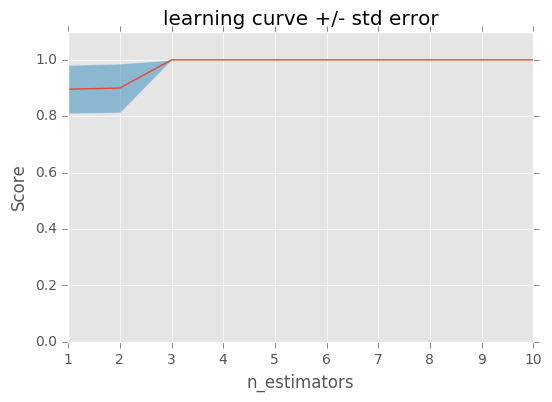

In [18]:
tree = ensemble.RandomForestClassifier(random_state=seed)
plot_learning_curve(tree, {'n_estimators':range(1,11)}, X_train, y_train, cv)

### Gradient Boosting (boosting method)

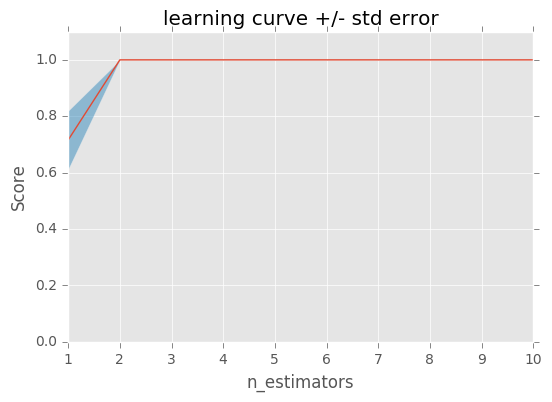

In [19]:
sgdb = ensemble.GradientBoostingClassifier(random_state=seed, learning_rate=0.1)
plot_learning_curve(sgdb, {'n_estimators':range(1,11)}, X_train, y_train, cv)

### Multilayer perceptron

In [20]:
from keras.models import Sequential
from keras.layers import Dense, Dropout

Using Theano backend.


In [21]:
# perform one-hot encoding for y-values
encoder = preprocessing.OneHotEncoder()
y_encoded = encoder.fit_transform(y.values.reshape(-1,1)) # one-hot encoding

y_train_encoded, y_test_encoded = y_encoded[:train_size], y_encoded[train_size:]

y_train_encoded.shape, y_test_encoded.shape

((913, 2), (229, 2))

In [22]:
np.random.seed(seed)
epochs = 100
batch_size = 8


model = Sequential()
model.add(Dense(50, activation='relu', input_dim=X_train.shape[1]))
model.add(Dropout(0.2))
model.add(Dense(100, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(50, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(2,activation='softmax'))
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

In [23]:
history = model.fit(X_train.values, y_train_encoded.toarray(), nb_epoch=epochs, batch_size=batch_size, verbose=1)

Epoch 1/100
913/913 [==============================] - 0s - loss: 0.6787 - acc: 0.6068     
Epoch 2/100
913/913 [==============================] - 0s - loss: 0.5757 - acc: 0.7251     
Epoch 3/100
913/913 [==============================] - 0s - loss: 0.3880 - acc: 0.8412     
Epoch 4/100
913/913 [==============================] - 0s - loss: 0.2660 - acc: 0.8872     
Epoch 5/100
913/913 [==============================] - 0s - loss: 0.2230 - acc: 0.9025     
Epoch 6/100
913/913 [==============================] - 0s - loss: 0.1526 - acc: 0.9398     
Epoch 7/100
913/913 [==============================] - 0s - loss: 0.1492 - acc: 0.9376     
Epoch 8/100
913/913 [==============================] - 0s - loss: 0.1340 - acc: 0.9409     
Epoch 9/100
913/913 [==============================] - 0s - loss: 0.1213 - acc: 0.9507     
Epoch 10/100
913/913 [==============================] - 0s - loss: 0.0990 - acc: 0.9628     
Epoch 11/100
913/913 [==============================] - 0s - loss: 0.0940 - acc

In [24]:
loss, accuracy = model.evaluate(X_test.values, y_test_encoded.toarray(), batch_size=batch_size)
print("Loss: %.2f, Accuracy: %.2f%%" % (loss, accuracy*100))

216/229 [===========================>..] - ETA: 0sLoss: 0.02, Accuracy: 99.13%


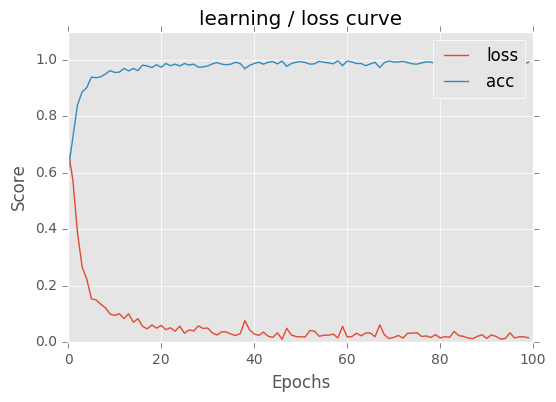

In [25]:
plt.plot(history.history['loss'], label='loss')
plt.plot(history.history['acc'], label='acc')
plt.legend()
plt.xlabel('Epochs')
plt.ylabel('Score')
plt.title('learning / loss curve')
plt.ylim(0,1.1)
plt.show()

## Summary

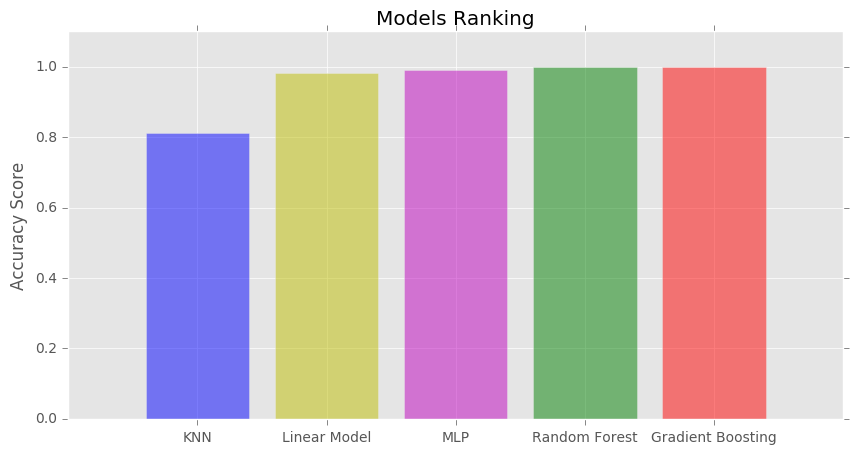

In [26]:
sgd.fit(X_train, y_train)
knn.fit(X_train, y_train)
tree.fit(X_train, y_train)
sgdb.fit(X_train, y_train)

scores = [
    ('Linear Model', sgd.score(X_test, y_test)), 
    ('KNN', knn.score(X_test, y_test)),
    ('Random Forest',tree.score(X_test, y_test)), 
    ('Gradient Boosting',sgdb.score(X_test, y_test)),
    ('MLP', accuracy)
]

models = [i[0] for i in sorted(scores, key=lambda x: x[1])]
scores = [i[1] for i in sorted(scores, key=lambda x: x[1])]
colors = ['b','y','m','g','r']

plt.figure(figsize=(10,5))
y = range(len(models))
plt.bar(y, scores, align='center', alpha=0.5, color=colors)
plt.ylabel('Accuracy Score')
plt.xticks(y, models)
plt.ylim(0,1.1)
plt.title('Models Ranking')

plt.show()